# Import Libraries

In [3]:
import numpy as np
import pandas as pd

from xgboost import XGBRegressor

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, GroupShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Load the data

In [4]:
df = pd.read_csv("../data/processed/youtube_combined_data.csv")
print(f"Data loaded with shape: {df.shape}")

%run "./02_data_cleaning.ipynb"
%run "./03_feature_engineering.ipynb"

df = clean_data(df)
df = feature_engineering(df)
df = drop_unused_columns(df)

print(f"Data after preprocessing has shape: {df.shape}")


Data loaded with shape: (50160, 16)
Data after preprocessing has shape: (49229, 17)


In [5]:
# Define target and feature lists

target = "engagement_rate_log"

categorical_features = ['category_id', 'captions_flag']

numeric_features = [
    'total_videos','channel_age_days','title_length','title_words',
    'title_exclamation','title_question',
    'duration_minutes','publish_hour_sin','publish_hour_cos',
    'publish_dow_sin','publish_dow_cos',
    'subscriber_count_log','is_hd'
]

all_features = categorical_features + numeric_features


# GROUP SPLIT

In [6]:
X = df[all_features].copy()
y = df[target].copy()
groups = df['channel_id']

gss = GroupShuffleSplit(
    test_size=0.2,
    n_splits=1,
    random_state=42
)

train_idx, test_idx = next(gss.split(X, y, groups))

X_train = X.iloc[train_idx].copy()
X_test  = X.iloc[test_idx].copy()
y_train = y.iloc[train_idx].copy()
y_test  = y.iloc[test_idx].copy()


In [7]:
train_means = y_train.groupby(X_train['category_id']).mean()

X_train['category_te'] = X_train['category_id'].map(train_means)
X_test['category_te']  = X_test['category_id'].map(train_means)

numeric_features.append('category_te')


In [8]:
# Clipping of numeric features

def robust_clip(train_col, test_col):
    q1, q3 = train_col.quantile([0.25, 0.75])
    iqr = q3 - q1
    lo, hi = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return train_col.clip(lo, hi), test_col.clip(lo, hi)


for col in ['total_videos', 'channel_age_days']:
    X_train[col], X_test[col] = robust_clip(X_train[col], X_test[col])


In [9]:
for col in categorical_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col]  = X_test[col].astype('category')


# Model Fit

In [10]:
base_model = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,

    subsample=0.85,
    colsample_bytree=0.8,
    colsample_bylevel=1.0,

    reg_alpha=5,
    reg_lambda=10,

    enable_categorical=True,
    tree_method="hist",
    verbosity=0
)


In [11]:
param_grid = {
    "learning_rate": [0.03, 0.05],
    "max_depth": [4, 5],
    "min_child_weight": [1, 3],
    "colsample_bytree": [0.7, 0.8],
    "gamma": [0, 1],
    "n_estimators": [300, 600]
}

search = HalvingGridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    factor=2,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=1
)

search.fit(X_train, y_train)

print("BEST PARAMS:", search.best_params_)


n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 616
max_resources_: 39475
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 64
n_resources: 616
Fitting 3 folds for each of 64 candidates, totalling 192 fits
----------
iter: 1
n_candidates: 32
n_resources: 1232
Fitting 3 folds for each of 32 candidates, totalling 96 fits
----------
iter: 2
n_candidates: 16
n_resources: 2464
Fitting 3 folds for each of 16 candidates, totalling 48 fits
----------
iter: 3
n_candidates: 8
n_resources: 4928
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 4
n_candidates: 4
n_resources: 9856
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 5
n_candidates: 2
n_resources: 19712
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 6
n_candidates: 1
n_resources: 39424
Fitting 3 folds for each of 1 candidates, totalling 3 fits
BEST PARAMS: {'colsample_bytree': 0.8, 'gamma': 0, 'lea

In [12]:
final_model = XGBRegressor(
    **search.best_params_,
    objective="reg:squarederror",

    subsample=0.85,
    reg_alpha=5,
    reg_lambda=10,

    random_state=42,
    enable_categorical=True,
    tree_method="hist",
    verbosity=0
)

final_model.fit(X_train, y_train)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,True
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [13]:
y_pred = np.clip(
    final_model.predict(X_test),
    y_train.min(),
    y_train.max()
)

y_train_pred = np.clip(
    final_model.predict(X_train),
    y_train.min(),
    y_train.max()
)


# Evaluation

In [14]:
print("\n====== TEST PERFORMANCE ======")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))

print("\n====== TRAIN PERFORMANCE ======")
print("MAE:", mean_absolute_error(y_train, y_train_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("R2:", r2_score(y_train, y_train_pred))



====== TEST PERFORMANCE ======
MAE: 0.1513637127393998
RMSE: 0.20684572780675844
R2: 0.29250765976230986

====== TRAIN PERFORMANCE ======
MAE: 0.13609220975004338
RMSE: 0.18819887498594973
R2: 0.40084870397307426


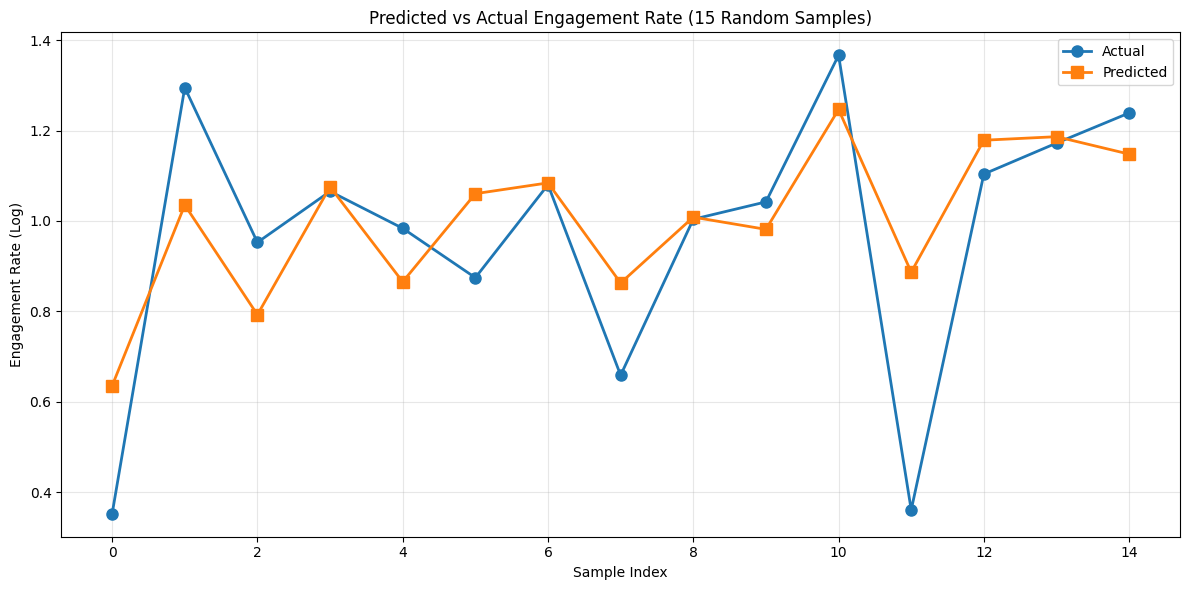

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Select random 15 indices from test set
random_indices = np.random.choice(len(y_test), 15, replace=False)
random_indices = sorted(random_indices)

# Get actual and predicted values
actual_values = y_test.iloc[random_indices].values
predicted_values = y_pred[random_indices]

# Create line chart
plt.figure(figsize=(12, 6))
plt.plot(range(15), actual_values, marker='o', label='Actual', linewidth=2, markersize=8)
plt.plot(range(15), predicted_values, marker='s', label='Predicted', linewidth=2, markersize=8)
plt.xlabel('Sample Index')
plt.ylabel('Engagement Rate (Log)')
plt.title('Predicted vs Actual Engagement Rate (15 Random Samples)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()